# 周期的波形の異常検知：（Isolation Forest;  iForest）

スモールデータ解析と機械学習の 6.2章
https://www.ohmsha.co.jp/book/9784274227783/


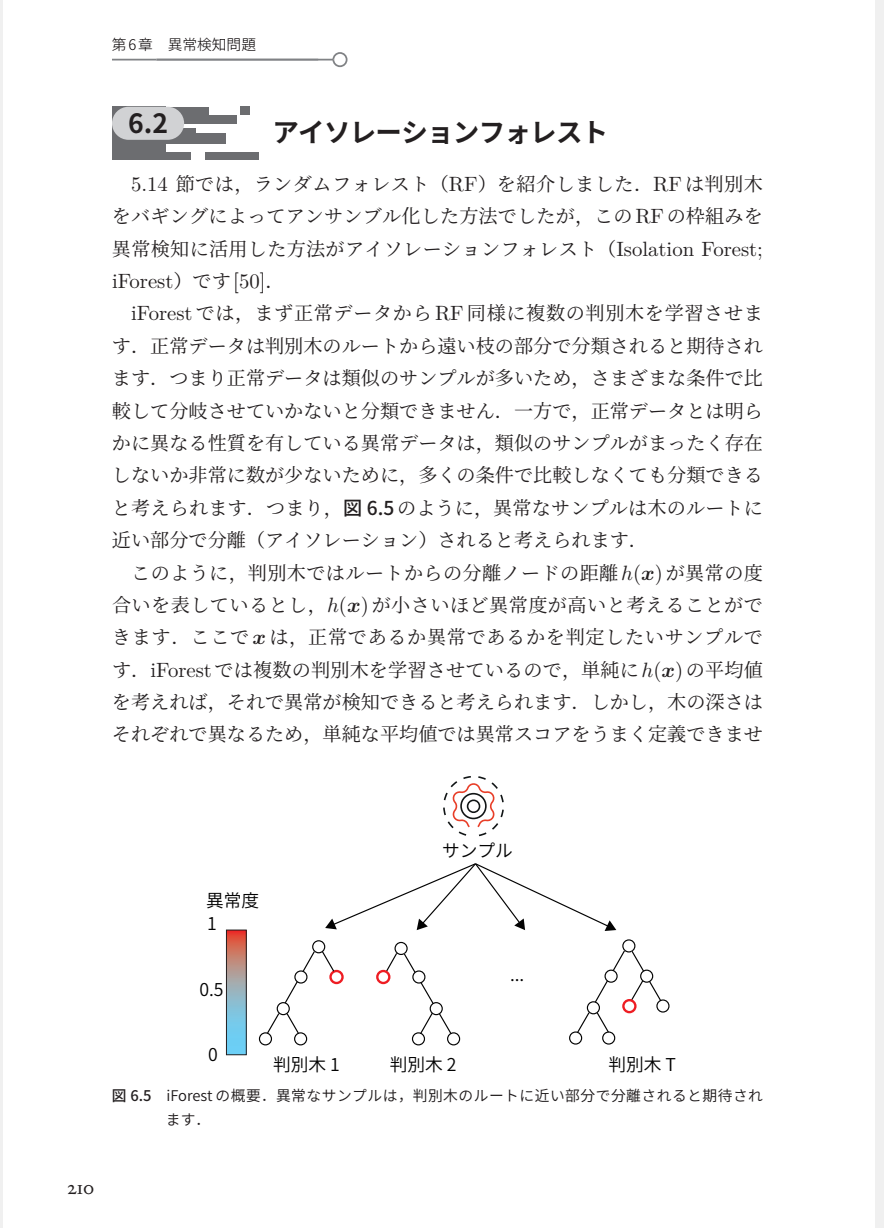

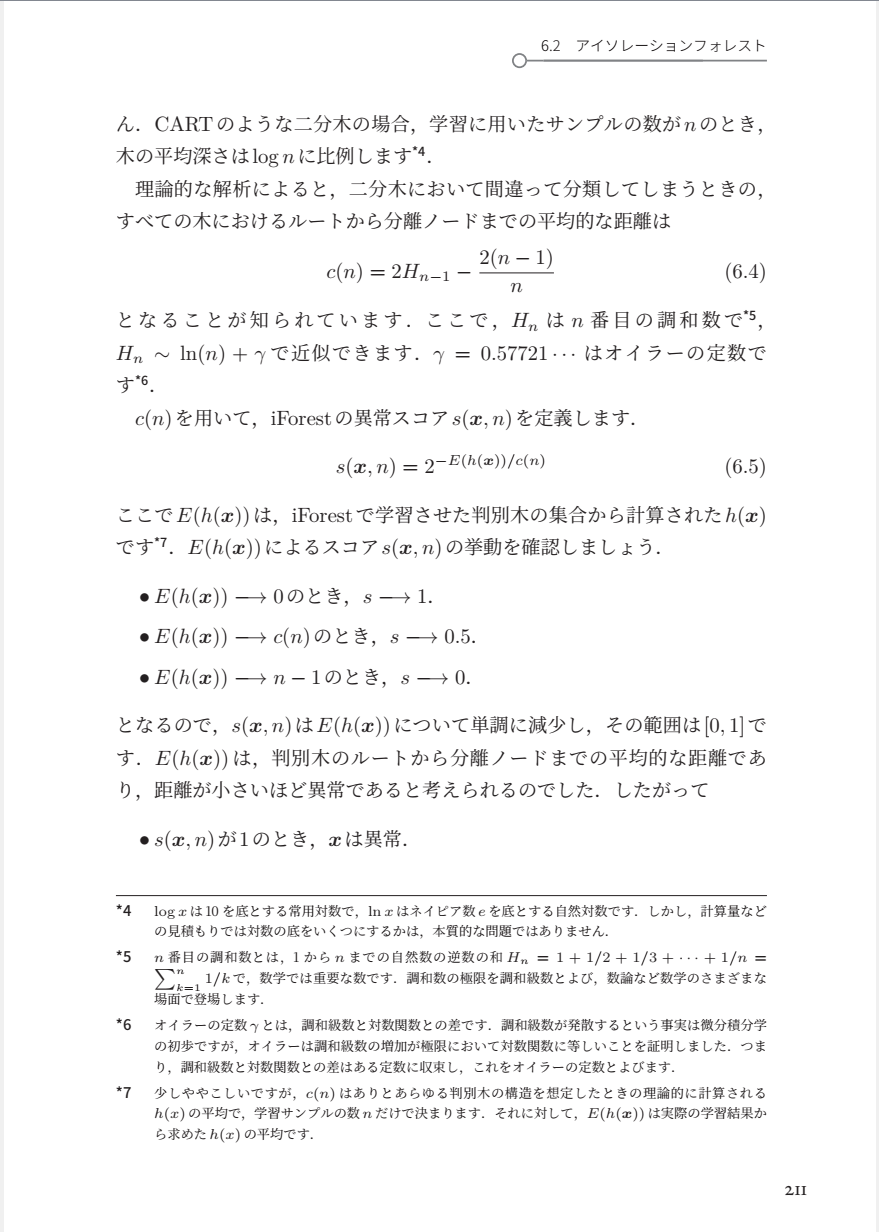

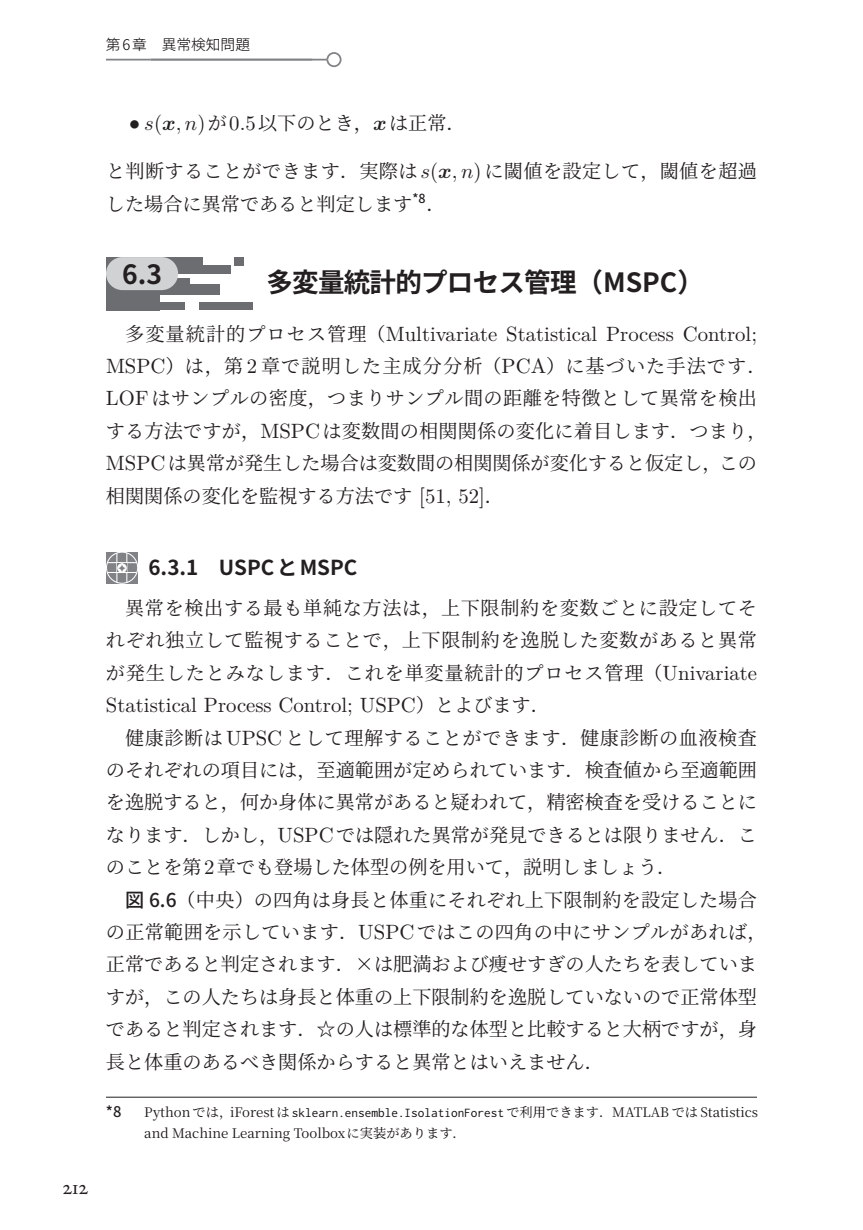

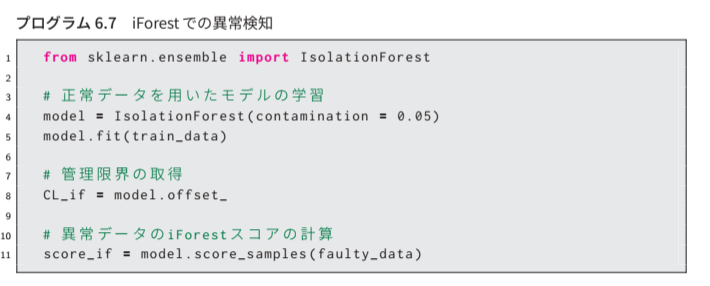

In [11]:
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

# ============================================================
# 設定（ここだけ変えればOK）
# ============================================================
NORMAL_CSV  = "..\\sampleData\\csv_TEPdata\\tuning-data.csv"    # 正常データ
ANOMALY_CSV = "..\\sampleData\\csv_TEPdata\\idv_str14_data.csv"   # 異常データ
ANOMALY_CSV = "..\\sampleData\\csv_TEPdata\\idv_str1_data.csv"   # 異常データ


TIME_COL  = "None"               # 無ければ None
LABEL_COL = "None"           # 無ければ None

# 特徴量列を明示したいなら list で指定（例: ["s1","s2","s3"]）
# None の場合は「数値列」から TIME_COL/LABEL_COL を除いたものを自動採用
FEATURE_COLS = None



# ============================================================
# 0) 入力
# ============================================================
df_normal = pd.read_csv(NORMAL_CSV)
df_anom   = pd.read_csv(ANOMALY_CSV)

# ============================================================
# 1) 特徴量列を決める
# ============================================================
if FEATURE_COLS is None:
    cols = df_normal.select_dtypes(include=[np.number]).columns.tolist()
    if TIME_COL is not None and TIME_COL in cols:
        cols.remove(TIME_COL)
    if LABEL_COL is not None and LABEL_COL in cols:
        cols.remove(LABEL_COL)
    FEATURE_COLS = cols

# 最低限の安全チェック（異常側にも同じ列がある前提）
missing = [c for c in FEATURE_COLS if c not in df_anom.columns]
if missing:
    raise ValueError(f"ANOMALY_CSV に特徴量列がありません: {missing}")

Xn = df_normal[FEATURE_COLS].to_numpy()
Xa = df_anom[FEATURE_COLS].to_numpy()

# ============================================================
# 2) 標準化（学習は正常データ基準）
# ============================================================
scaler = StandardScaler()
Xn_std = scaler.fit_transform(Xn)
Xa_std = scaler.transform(Xa)

df_normal

,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,xmeas_7,xmeas_8,xmeas_9,xmeas_10,...,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
0,0.24924,3654.2,4519.2,9.2698,26.769,42.339,2704.5,74.952,120.41,0.34019,...,53.861,24.770,60.431,22.290,39.690,41.286,44.349,47.435,41.470,17.910
1,0.24959,3690.6,4513.5,9.3137,26.794,42.445,2703.6,75.036,120.40,0.33621,...,53.930,24.735,60.271,22.049,40.175,38.312,46.742,47.436,41.055,18.488
2,0.25055,3643.8,4517.5,9.3308,26.998,41.926,2705.6,75.036,120.39,0.33664,...,53.882,24.648,60.502,22.675,40.121,35.751,47.901,47.431,41.345,17.261
3,0.24887,3665.5,4492.1,9.3629,26.688,42.371,2707.0,75.376,120.41,0.33615,...,54.185,24.814,63.408,22.199,40.181,38.001,45.551,47.532,41.038,16.666
4,0.23429,3678.8,4553.1,9.3525,27.317,42.498,2705.9,74.286,120.38,0.33272,...,53.717,22.800,61.428,22.404,39.619,40.402,48.971,47.469,41.225,17.967
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
955,0.20487,3644.7,4548.5,9.3260,26.712,42.313,2716.9,75.908,120.38,0.32882,...,53.760,20.162,60.099,22.650,38.795,39.310,51.706,45.149,40.759,18.591
956,0.24919,3624.2,4580.6,9.2399,26.905,42.485,2718.4,75.737,120.38,0.33182,...,54.678,24.671,62.399,22.625,39.652,46.369,48.481,45.429,40.401,20.054
957,0.24994,3608.9,4546.7,9.3140,27.199,42.817,2718.1,75.075,120.41,0.32998,...,55.083,24.597,60.986,22.933,39.877,35.511,46.386,45.333,40.491,15.915
958,0.26286,3671.9,4509.6,9.2544,26.769,41.869,2717.1,73.661,120.38,0.32418,...,55.146,25.705,61.088,22.350,37.666,39.908,48.880,45.291,40.263,17.230


FEATURE_COLS: ['xmeas_1', 'xmeas_2', 'xmeas_3', 'xmeas_4', 'xmeas_5', 'xmeas_6', 'xmeas_7', 'xmeas_8', 'xmeas_9', 'xmeas_10', 'xmeas_11', 'xmeas_12', 'xmeas_13', 'xmeas_14', 'xmeas_15', 'xmeas_16', 'xmeas_17', 'xmeas_18', 'xmeas_19', 'xmeas_20', 'xmeas_21', 'xmeas_22', 'xmeas_23', 'xmeas_24', 'xmeas_25', 'xmeas_26', 'xmeas_27', 'xmeas_28', 'xmeas_29', 'xmeas_30', 'xmeas_31', 'xmeas_32', 'xmeas_33', 'xmeas_34', 'xmeas_35', 'xmeas_36', 'xmeas_37', 'xmeas_38', 'xmeas_39', 'xmeas_40', 'xmeas_41', 'xmv_1', 'xmv_2', 'xmv_3', 'xmv_4', 'xmv_5', 'xmv_6', 'xmv_7', 'xmv_8', 'xmv_9', 'xmv_10', 'xmv_11']
normal score (min/mean/max): 0.3650649937290914 0.44024090879179983 0.5381087252979193
anomaly score (min/mean/max): 0.3860677661208318 0.5510430076883589 0.6993298465012137


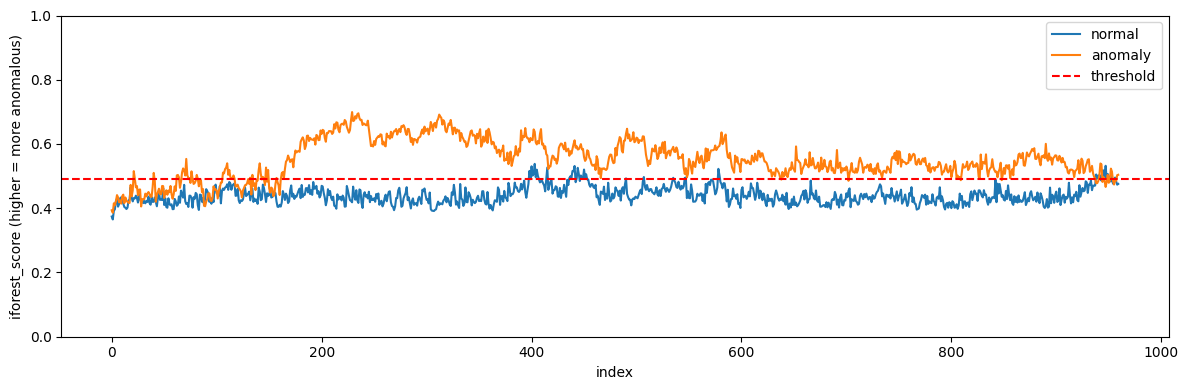

In [12]:

# ============================================================
# 3) iForest 学習（正常データのみで学習）
# ============================================================

# iForest 設定
CONTAMINATION = 0.05
RANDOM_STATE  = 0

model = IsolationForest(
    contamination=CONTAMINATION,
    random_state=RANDOM_STATE
)
model.fit(Xn_std)

# ============================================================
# 4) 異常度スコア（「負を正」に：-score_samples）
#    score_samples は「小さいほど異常」なので、符号反転して
#    「大きいほど異常」のスコアにする
# ============================================================
score_normal = -model.score_samples(Xn_std)
score_anom   = -model.score_samples(Xa_std)
thr          = -model.offset_                 # score と同じ向きの閾値

# ============================================================
# 5) 結果を DataFrame に追加（元の列は維持）
# ============================================================

if TIME_COL is not None and TIME_COL in df_normal.columns:
    t_normal = df_normal[TIME_COL].to_numpy()
else:
    t_normal = np.arange(len(score_normal))

if TIME_COL is not None and TIME_COL in df_anom.columns:
    t_anom = df_anom[TIME_COL].to_numpy()
else:
    t_anom = np.arange(len(score_anom))

df_score_normal = pd.DataFrame({ "t": t_normal, "iforest_score": score_normal })
df_score_anom   = pd.DataFrame({ "t": t_anom,   "iforest_score": score_anom   })

df_score_all = pd.concat(
    [
        df_score_normal.assign(_source="normal"),
        df_score_anom.assign(_source="anomaly"),
    ],
    ignore_index=True
)

print("FEATURE_COLS:", FEATURE_COLS)
print("normal score (min/mean/max):",
      float(score_normal.min()), float(score_normal.mean()), float(score_normal.max()))
print("anomaly score (min/mean/max):",
      float(score_anom.min()), float(score_anom.mean()), float(score_anom.max()))

# ============================================================
# 6) プロット（スコアのみ）
# ============================================================
import matplotlib.pyplot as plt

FIGSIZE = (12, 4)   # (横, 縦)
YLIM    = (0,1)      # 例: (0, 1.0) / 自動なら None

plt.figure(figsize=FIGSIZE)
plt.plot(t_normal, score_normal, label="normal")
plt.plot(t_anom,   score_anom,   label="anomaly")
plt.axhline(thr, linestyle="--", label="threshold", color="red")
plt.xlabel("t" if (TIME_COL and TIME_COL in df_normal.columns and TIME_COL in df_anom.columns) else "index")
plt.ylabel("iforest_score (higher = more anomalous)")
if YLIM is not None:
    plt.ylim(*YLIM)
plt.legend()
plt.tight_layout()
plt.show()


iForestだと検知しにくい場合があることを確認。

1番目と14番目を比較するとわかる。